In [25]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans

In [26]:
def load_images_from_folder(folder, max_images=10000):
    images = []
    for filename in os.listdir(folder):
        if len(images) >= max_images:
            break
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [27]:
def extract_features(images):
    sift = cv2.SIFT_create()
    descriptors_list = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, descriptors = sift.detectAndCompute(gray, None)
        if descriptors is not None:
            descriptors_list.append(descriptors)
    return descriptors_list

In [28]:
def create_feature_histogram(descriptor_list, cluster_model):
    all_descriptors = np.vstack(descriptor_list)
    features = cluster_model.predict(all_descriptors)
    histogram, _ = np.histogram(features, bins=np.arange(0, len(cluster_model.cluster_centers_) + 1), density=True)
    return histogram

In [29]:
# Load images
train_real_path = r"D:\AI Labs - Python\Pattern Recognition\PreProcessing-CIFAKE\train\REAL"
train_fake_path = r"D:\AI Labs - Python\Pattern Recognition\PreProcessing-CIFAKE\train\FAKE"
train_real_images = load_images_from_folder(train_real_path, 10000)
train_fake_images = load_images_from_folder(train_fake_path, 10000)

In [30]:
# Extract features
real_descriptors = extract_features(train_real_images)
fake_descriptors = extract_features(train_fake_images)

In [31]:
# Flatten all descriptors to fit k-means
all_descriptors = [desc for sublist in real_descriptors + fake_descriptors for desc in sublist if desc is not None]
all_descriptors = np.vstack(all_descriptors)

In [32]:
# Create a k-means model to find visual words
n_clusters = 130
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(all_descriptors)

D:\jupyter\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


MiniBatchKMeans(n_clusters=130, random_state=42)

In [33]:
# Create histograms for each set of descriptors
X_real = np.array([create_feature_histogram(desc, kmeans) if desc is not None else np.zeros(n_clusters) for desc in real_descriptors])
X_fake = np.array([create_feature_histogram(desc, kmeans) if desc is not None else np.zeros(n_clusters) for desc in fake_descriptors])
X = np.vstack([X_real, X_fake])
y = np.array([1]*len(X_real) + [0]*len(X_fake))

In [34]:
# Apply PCA to reduce dimensionality
pca = PCA()
X_pca = pca.fit_transform(X)
n_components_chosen = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.95)[0][0] + 1
X_pca = PCA(n_components=n_components_chosen).fit_transform(X)

In [35]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
# Define function to evaluate models
def evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test, title):
    model.fit(X_train_scaled, y_train)
    probabilities = model.predict_proba(X_test_scaled)[:, 1]
    train_probabilities = model.predict_proba(X_train_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    predictions = (probabilities >= optimal_threshold).astype(int)
    train_predictions = (train_probabilities >= optimal_threshold).astype(int)
    print(title)
    print("Train Accuracy:", accuracy_score(y_train, train_predictions))
    print("Test Accuracy:", accuracy_score(y_test, predictions))
    print("Classification Report (Test):")
    print(classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix', size=15)
    plt.show()

In [37]:
# Initialize the base models with the specified parameters
logistic_finalmodel = LogisticRegression(solver='saga', max_iter=1000)
svm_finalmodel = SVC(C=1, kernel='linear', probability=True)

In [38]:
# Voting Classifier using hard voting
voting_clf_hard = VotingClassifier(
    estimators=[('lr', logistic_finalmodel), ('svm', svm_finalmodel)],
    voting='soft'
)

SVM final Results
Train Accuracy: 0.6749375
Test Accuracy: 0.66525
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.64      0.74      0.69      1981
           1       0.70      0.59      0.64      2019

    accuracy                           0.67      4000
   macro avg       0.67      0.67      0.66      4000
weighted avg       0.67      0.67      0.66      4000



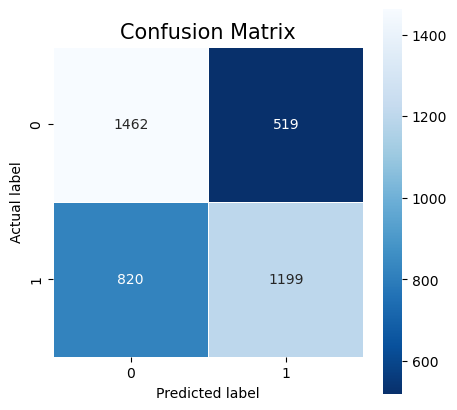

In [39]:
# Evaluate models
evaluate_model(svm_finalmodel, X_train_scaled, y_train, X_test_scaled, y_test, "SVM final Results")

Logistic Regression Final Results
Train Accuracy: 0.6746875
Test Accuracy: 0.6655
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.64      0.74      0.69      1981
           1       0.70      0.60      0.64      2019

    accuracy                           0.67      4000
   macro avg       0.67      0.67      0.66      4000
weighted avg       0.67      0.67      0.66      4000



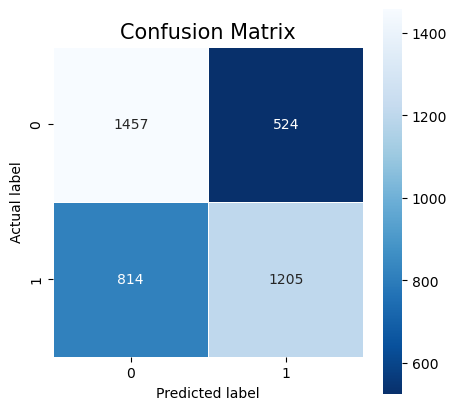

In [40]:
evaluate_model(logistic_finalmodel, X_train_scaled, y_train, X_test_scaled, y_test, "Logistic Regression Final Results")

In [45]:
# Stacking Classifier with Logistic Regression as the final estimator
stacking_newclf = StackingClassifier(
    estimators=[('svm', svm_finalmodel), ('lr', logistic_finalmodel)],
    final_estimator=LogisticRegression()
)

Ensemble Stacking Results
Train Accuracy: 0.673875
Test Accuracy: 0.66625
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.64      0.74      0.69      1981
           1       0.70      0.59      0.64      2019

    accuracy                           0.67      4000
   macro avg       0.67      0.67      0.66      4000
weighted avg       0.67      0.67      0.66      4000



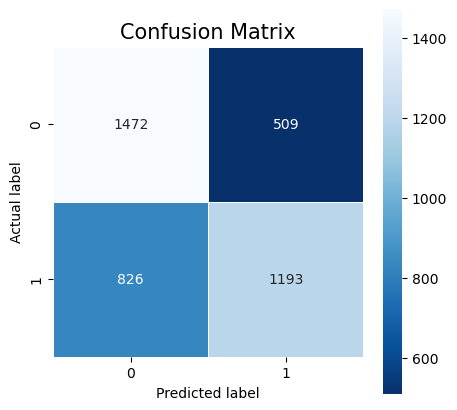

In [46]:
evaluate_model(stacking_newclf, X_train_scaled, y_train, X_test_scaled, y_test, "Ensemble Stacking Results")

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming the models are already trained, you would calculate the probabilities like this:
probabilities_svm = svm_model.predict_proba(X_test_scaled)[:, 1]  # SVM probabilities for the positive class
probabilities_lr = logistic_model.predict_proba(X_test_scaled)[:, 1]  # Logistic Regression probabilities
probabilities_ensemble = ensemble_model.predict_proba(X_test_scaled)[:, 1]  # Ensemble probabilities

In [19]:
# Calculate ROC curve and ROC area for each model
fpr_svm, tpr_svm, _ = roc_curve(y_test, probabilities_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_lr, tpr_lr, _ = roc_curve(y_test, probabilities_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, probabilities_ensemble)
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

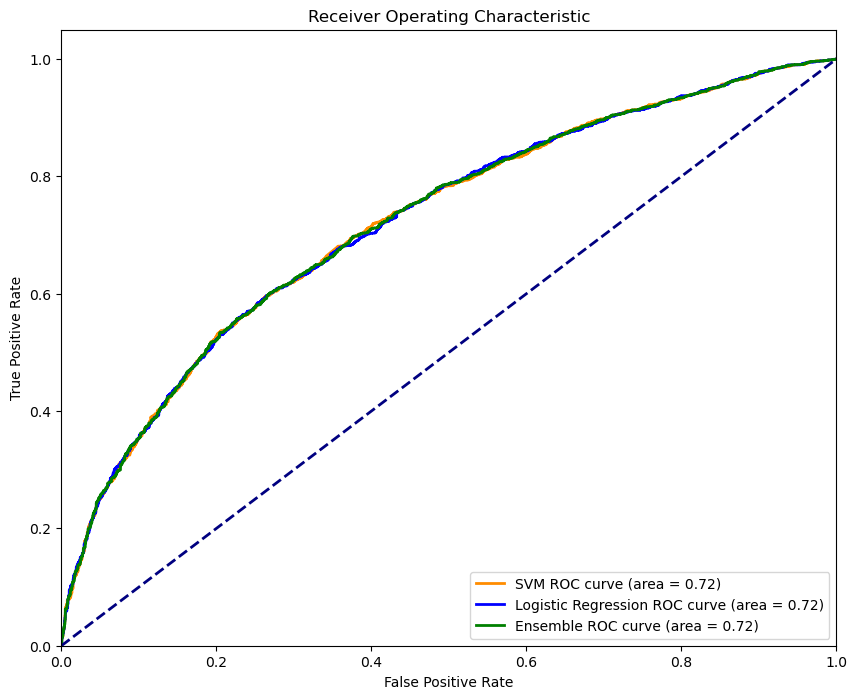

In [20]:
# Plotting
plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='SVM ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label='Logistic Regression ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot(fpr_ensemble, tpr_ensemble, color='green', lw=2, label='Ensemble ROC curve (area = %0.2f)' % roc_auc_ensemble)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

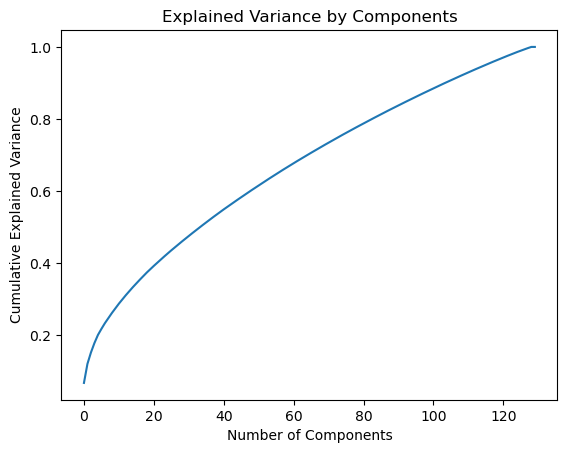

Maximum cumulative explained variance: 0.9999999999999998


In [23]:
pca = PCA()
X_pca = pca.fit_transform(X)

# Plot the explained variance to understand the distribution
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

# Print maximum cumulative explained variance
print("Maximum cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_).max())

In [24]:
# Determine the number of components that explain at least 95% of the variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
try:
    n_components_chosen = np.where(cumulative_variance >= 0.95)[0][0] + 1
except IndexError:
    n_components_chosen = len(pca.explained_variance_ratio_)  # Use all components if 95% is not contained
    print("95% variance not reached with the discrete components, using all components:", n_components_chosen)

# Apply PCA with the chosen number of components
pca = PCA(n_components=n_components_chosen)
X_pca = pca.fit_transform(X)
print("Number of PCA components chosen to explain at least 95% variance:", n_components_chosen)

Number of PCA components chosen to explain at least 95% variance: 116
